In [1]:
!git clone https://github.com/sathishkumar67/PODFCSSV.git
!mv PODFCSSV/* ./

Cloning into 'PODFCSSV'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 116 (delta 34), reused 90 (delta 15), pack-reused 0 (from 0)
Receiving objects: 100% (116/116), 3.89 MiB | 30.40 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [2]:
from src.mae_with_adapter import *

2025-12-27 09:54:54.756917: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766829294.912813      86 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766829294.958260      86 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [3]:
image_path_1 = "/kaggle/input/wild-animal-detection-and-alerting-system/dataset/test_set/domestic"
image_path_2 = "/kaggle/input/wild-animal-detection-and-alerting-system/dataset/test_set/wild"

In [ ]:
model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-huge")

# Inject Adapters
model = inject_adapters(model, bottleneck_dim=64)

# Sanity Check: Forward pass
print("[Main] Running dummy forward pass to verify graph integrity...")
dummy_input = torch.randn(1, 3, 224, 224)

# Forward pass (ensure gradients flow through adapters)
output = model(dummy_input)

print(f"[Success] Forward pass complete. Loss: {output.loss.item():.4f}")

In [5]:
import os
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [6]:
class ImageFolderDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.image_files = [
            f for f in os.listdir(folder_path)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),   # Converts to [0,1] and CHW format
])

In [7]:
dataset_1 = ImageFolderDataset(
    folder_path=image_path_1,
    transform=transform
)

dataloader = DataLoader(
    dataset_1,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

dataset_2 = ImageFolderDataset(
    folder_path=image_path_2,
    transform=transform
)   
dataloader_2 = DataLoader(
    dataset_2,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

In [22]:
from transformers import ViTMAEModel

client_1 = ViTMAEModel.from_pretrained("facebook/vit-mae-base", mask_ratio=0).to("cuda")
client_2 = ViTMAEModel.from_pretrained("facebook/vit-mae-base", mask_ratio=0).to("cuda")

In [21]:
features_1 = []
features_2 = []

In [24]:
for batch in dataloader:
    with torch.no_grad():
        outputs = client_1(batch.to("cuda"))
        features_1.append(outputs.last_hidden_state[:, 0, :].cpu())
for batch in dataloader_2:
    with torch.no_grad():
        outputs = client_2(batch.to("cuda"))
        features_2.append(outputs.last_hidden_state[:, 0, :].cpu())

In [25]:
len(features_1), len(features_2)

(38, 40)

In [30]:
import torch.nn.functional as F
Z1 = F.normalize(torch.cat(features_1, dim=0), dim=1)
Z2 = F.normalize(torch.cat(features_2, dim=0), dim=1)
Z1.shape, Z2.shape

(torch.Size([150, 768]), torch.Size([160, 768]))

In [ ]:
import math
K1 = math.sqrt(150).
K2 = math.sqrt(160)
K1, K2

(12.24744871391589, 12.649110640673518)

In [20]:
client_1(next(iter(dataloader))).last_hidden_state.shape

torch.Size([4, 197, 768])

In [1]:
import torch
import matplotlib.pyplot as plt
from PIL import Image

from transformers import ViTMAEForPreTraining, ViTImageProcessor

In [46]:
from transformers import ViTMAEModel

In [48]:
ViTMAEModel.from_pretrained("facebook/vit-mae-base")

ViTMAEModel(
  (embeddings): ViTMAEEmbeddings(
    (patch_embeddings): ViTMAEPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
  )
  (encoder): ViTMAEEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTMAELayer(
        (attention): ViTMAEAttention(
          (attention): ViTMAESelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): ViTMAESelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTMAEIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ViTMAEOutput(
          (dense): Linear(i

In [49]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = ViTMAEForPreTraining.from_pretrained(
    "facebook/vit-mae-base"
).to(device)

processor = ViTImageProcessor.from_pretrained("facebook/vit-mae-base")

model.eval()

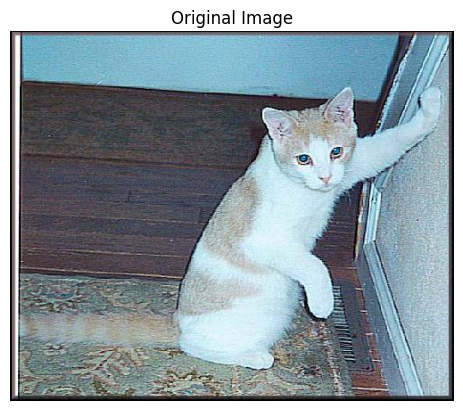

In [4]:
image_path = "/kaggle/input/wild-animal-detection-and-alerting-system/dataset/test_set/domestic/domestic (1).jpg"   # <-- put your image path here
image = Image.open(image_path).convert("RGB")

plt.imshow(image)
plt.axis("off")
plt.title("Original Image")
plt.show()

In [6]:
inputs = processor(images=image, return_tensors="pt")
pixel_values = inputs["pixel_values"].to(device)
pixel_values.shape

torch.Size([1, 3, 224, 224])

In [28]:
model.config.mask_ratio = 0.00

In [29]:
with torch.no_grad():
    outputs = model(pixel_values)
    loss = outputs.loss
    reconstructed = outputs.logits

In [30]:
reconstructed.shape

torch.Size([1, 196, 768])

In [31]:
# Unpatchify
reconstructed = model.unpatchify(reconstructed)

# Move to CPU
reconstructed = reconstructed.cpu()

# De-normalize
mean = torch.tensor(processor.image_mean).view(1, 3, 1, 1)
std = torch.tensor(processor.image_std).view(1, 3, 1, 1)

reconstructed = reconstructed * std + mean
reconstructed = torch.clamp(reconstructed, 0, 1)

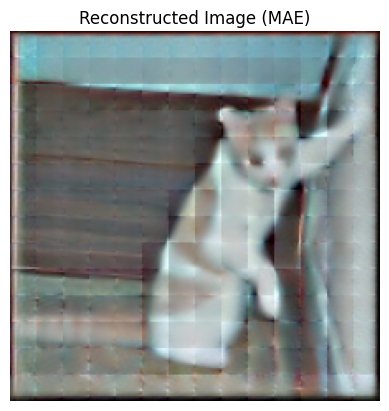

In [32]:
reconstructed_img = reconstructed[0].permute(1, 2, 0)

plt.imshow(reconstructed_img)
plt.axis("off")
plt.title("Reconstructed Image (MAE)")
plt.show()

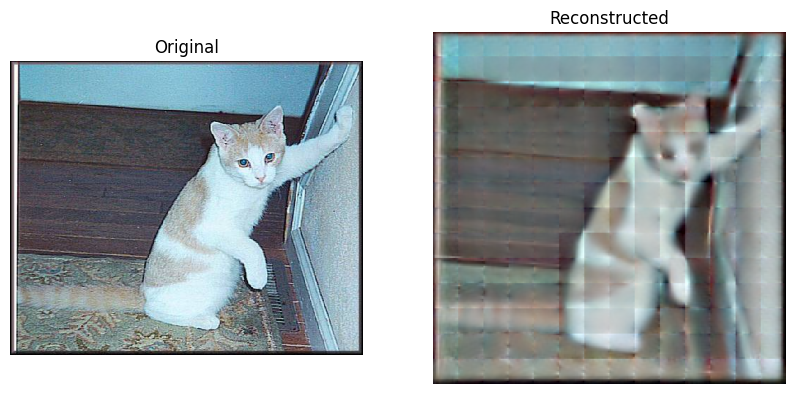

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(image)
ax[0].set_title("Original")
ax[0].axis("off")

ax[1].imshow(reconstructed_img)
ax[1].set_title("Reconstructed")
ax[1].axis("off")

plt.show()


In [36]:
# Calculate loss between original and reconstructed image
loss_fn = torch.nn.MSELoss()
original_img = torch.tensor(processor(image, return_tensors="pt")["pixel_values"]).to(device)
loss = loss_fn(original_img.to(device), reconstructed.to(device))
print(f"Loss between original and reconstructed image: {loss.item():.4f}")

Loss between original and reconstructed image: 0.8677


/tmp/ipykernel_86/4010246637.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  original_img = torch.tensor(processor(image, return_tensors="pt")["pixel_values"]).to(device)


# MAE Training (Self-Supervised)

This section configures and trains a ViT-MAE model on images in a folder. Provide the path to your images directory; subfolders are optional (labels are ignored).

In [ ]:
# Config and Imports
import os, math, time, random
from pathlib import Path
import numpy as np
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import ViTMAEForPreTraining, ViTImageProcessor, ViTMAEConfig

# Path to your images folder (change this)
data_dir = "/kaggle/input/wild-animal-detection-and-alerting-system/dataset/test_set/wild"  # e.g., C:\data\images

# Choose model: 'facebook/vit-mae-base' | 'facebook/vit-mae-large' | 'facebook/vit-mae-huge'
model_name = "facebook/vit-mae-base"

# Hyperparameters
epochs = 5
batch_size = 16
lr = 5e-4
weight_decay = 0.05
num_workers = 4
mask_ratio = 0.75
image_size = 224
amp = True
output_dir = "outputs/mae"
save_every = 1
seed = 42

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

def set_seed(s):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)
set_seed(seed)

Device: cuda


In [39]:
# Dataset and Processor
class FlatImageDataset(Dataset):
    def __init__(self, root):
        self.root = root
        exts = {".jpg",".jpeg",".png",".bmp",".gif",".webp"}
        files = []
        for r, _, fns in os.walk(root):
            for fn in fns:
                if os.path.splitext(fn)[1].lower() in exts:
                    files.append(os.path.join(r, fn))
        if not files:
            raise RuntimeError(f"No images found under {root}")
        self.files = sorted(files)
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        path = self.files[idx]
        img = Image.open(path).convert("RGB")
        return img

processor = ViTImageProcessor.from_pretrained(model_name)
processor.size = {"height": image_size, "width": image_size}

def collate_fn(batch):
    out = processor(images=batch, return_tensors="pt")
    return out["pixel_values"], None

dataset = FlatImageDataset(data_dir)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, drop_last=True, collate_fn=collate_fn)
len(dataset)

160

In [40]:
# Helper: save grid
def save_image_grid(tensor_bchw, out_path, nrow=4):
    B, C, H, W = tensor_bchw.shape
    nrow = min(nrow, B)
    ncol = math.ceil(B / nrow)
    canvas = torch.ones(C, ncol * H, nrow * W)
    idx = 0
    for r in range(ncol):
        for c in range(nrow):
            if idx >= B:
                break
            canvas[:, r*H:(r+1)*H, c*W:(c+1)*W] = tensor_bchw[idx]
            idx += 1
    canvas = (canvas.clamp(0, 1) * 255).byte().permute(1, 2, 0).numpy()
    Image.fromarray(canvas).save(out_path)

In [45]:
model.decoder

ViTMAEDecoder(
  (decoder_embed): Linear(in_features=768, out_features=512, bias=True)
  (decoder_layers): ModuleList(
    (0-7): 8 x ViTMAELayer(
      (attention): ViTMAEAttention(
        (attention): ViTMAESelfAttention(
          (query): Linear(in_features=512, out_features=512, bias=True)
          (key): Linear(in_features=512, out_features=512, bias=True)
          (value): Linear(in_features=512, out_features=512, bias=True)
        )
        (output): ViTMAESelfOutput(
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (intermediate): ViTMAEIntermediate(
        (dense): Linear(in_features=512, out_features=2048, bias=True)
        (intermediate_act_fn): GELUActivation()
      )
      (output): ViTMAEOutput(
        (dense): Linear(in_features=2048, out_features=512, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (layernorm_before): LayerNorm((512,), eps

In [ ]:
# Train MAE
config = ViTMAEConfig.from_pretrained(model_name)  # architecture only, random init
model = ViTMAEForPreTraining(config).to(device)
model.config.mask_ratio = float(mask_ratio)

optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
scaler = torch.cuda.amp.GradScaler(enabled=amp)

os.makedirs(output_dir, exist_ok=True)
best_loss = float("inf")

for epoch in range(1, epochs + 1):
    model.train()
    running = 0.0
    start = time.time()
    for i, (pixel_values, _) in enumerate(loader, start=1):
        pixel_values = pixel_values.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=amp):
            outputs = model(pixel_values)
            loss = outputs.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running += loss.item()
        if i % 50 == 0:
            print(f"Epoch {epoch} [{i}/{len(loader)}] loss={running / i:.4f}")
    epoch_loss = running / max(1, len(loader))
    scheduler.step()
    print(f"Epoch {epoch} done in {time.time() - start:.1f}s, loss={epoch_loss:.4f}")
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save({
            "epoch": epoch,
            "model_name": model_name,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": epoch_loss,
        }, os.path.join(output_dir, "best.pt"))
    if save_every > 0 and (epoch % save_every == 0):
        torch.save({
            "epoch": epoch,
            "model_name": model_name,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": epoch_loss,
        }, os.path.join(output_dir, f"epoch-{epoch}.pt"))
    # Visualize reconstructions
    model.eval()
    with torch.no_grad():
        try:
            pixel_values, _ = next(iter(loader))
            pixel_values = pixel_values.to(device)
            out = model(pixel_values)
            recon = model.unpatchify(out.logits)
            mean = torch.tensor(processor.image_mean, device=device).view(1, 3, 1, 1)
            std = torch.tensor(processor.image_std, device=device).view(1, 3, 1, 1)
            recon = torch.clamp(recon * std + mean, 0, 1).cpu()
            orig = torch.clamp(pixel_values.cpu() * std.cpu() + mean.cpu(), 0, 1)
            save_image_grid(recon[:8], os.path.join(output_dir, f"recon_epoch_{epoch}.png"), nrow=4)
            save_image_grid(orig[:8], os.path.join(output_dir, f"orig_epoch_{epoch}.png"), nrow=4)
            print("Saved visualization grids.")
        except Exception as e:
            print("Visualization failed:", e)

print("Training complete.")

/tmp/ipykernel_86/2098959356.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=amp)
/tmp/ipykernel_86/2098959356.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=amp):


Epoch 1 done in 2.7s, loss=0.3309
Saved visualization grids.
Epoch 2 done in 2.5s, loss=0.2557
Saved visualization grids.
Epoch 3 done in 2.4s, loss=0.2563
Saved visualization grids.
Epoch 4 done in 2.4s, loss=0.2418
Saved visualization grids.
Epoch 5 done in 2.4s, loss=0.2378
Saved visualization grids.
Training complete.


In [ ]:
import torch
import torch.nn as nn
from transformers import ViTMAEForPreTraining, ViTImageProcessor

In [2]:
class IBA_Adapter(nn.Module):
    def __init__(self, input_dim, bottleneck_dim=64, dropout=0.0):
        """
        Standard Bottleneck Adapter (Deterministic Phase).
        Structure: Down-Project -> GELU -> Up-Project -> Residual
        """
        super().__init__()
        self.input_dim = input_dim
        
        # The Bottleneck structure
        self.down_project = nn.Linear(input_dim, bottleneck_dim)
        self.activation = nn.GELU()
        self.up_project = nn.Linear(bottleneck_dim, input_dim)
        self.dropout = nn.Dropout(dropout)
        
        # Initialize weights near zero to ensure training starts close to identity
        nn.init.kaiming_normal_(self.down_project.weight)
        nn.init.zeros_(self.up_project.weight)
        nn.init.zeros_(self.up_project.bias)

    def forward(self, x):
        # x shape: [batch_size, seq_len, hidden_dim]
        residual = x
        
        # Bottleneck compression
        x = self.down_project(x)
        x = self.activation(x)
        
        # (Optional Future Upgrade): For "Zeus" version, inject variational noise here
        # x = x + torch.randn_like(x) * noise_scale 
        
        # Reconstruction
        x = self.up_project(x)
        x = self.dropout(x)
        
        # Residual connection
        return residual + x

In [3]:
class ViTBlockWithAdapter(nn.Module):
    def __init__(self, original_block, adapter):
        super().__init__()
        self.original_block = original_block  # The frozen MAE block
        self.adapter = adapter                # The new trainable adapter

    def forward(self, hidden_states, head_mask=None, output_attentions=False):
        # 1. Run the original frozen ViT Block
        # HF blocks return a tuple: (hidden_states, weights, etc.)
        outputs = self.original_block(
            hidden_states, 
            head_mask=head_mask, 
            output_attentions=output_attentions
        )
        
        # The hidden states are always the first element
        x = outputs[0]
        
        # 2. Run the IBA Adapter
        x = self.adapter(x)
        
        # 3. Repackage output to match HF format
        if output_attentions:
            return (x,) + outputs[1:]
        return (x,)

In [4]:
def inject_adapters(model, bottleneck_dim=64):
    """
    Iterates through the ViT encoder, freezes original weights,
    and wraps every layer with an Adapter.
    """
    
    # 1. Freeze the entire model first
    for param in model.parameters():
        param.requires_grad = False
        
    encoder = model.vit.encoder
    input_dim = model.config.hidden_size # 768 for Base
    
    print(f"Injecting Adapters (Dim: {input_dim} -> {bottleneck_dim} -> {input_dim})...")
    
    # 2. Iterate and Replace
    for i, layer in enumerate(encoder.layer):
        # Create the adapter
        adapter = IBA_Adapter(input_dim, bottleneck_dim)
        
        # Create the wrapper
        # We move adapter to correct device/dtype immediately
        device = next(layer.parameters()).device
        dtype = next(layer.parameters()).dtype
        adapter.to(device=device, dtype=dtype)
        
        wrapped_layer = ViTBlockWithAdapter(layer, adapter)
        
        # Replace the layer in the ModuleList
        encoder.layer[i] = wrapped_layer
        
    print("Injection Complete.")
    return model

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load Pre-trained MAE
print("Loading MAE...")
model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base").to(device)

# Verify Trainable Params BEFORE
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Original Params: {total_params:,} | Trainable: {trainable_params:,}")

# --- INJECT ADAPTERS ---
model = inject_adapters(model, bottleneck_dim=64)

# Verify Trainable Params AFTER
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Modified Params: {total_params:,} | Trainable: {trainable_params:,}")
print(f"Trainable Ratio: {100 * trainable_params / total_params:.2f}%")

# Test Forward Pass
print("\nTesting Forward Pass...")
dummy_input = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad(): # Just testing shape
    outputs = model(dummy_input)
    loss = outputs.loss
    logits = outputs.logits
    
print(f"Forward Pass Successful.")
print(f"Loss: {loss.item()}")
print(f"Logits Shape: {logits.shape}") # Should be [1, 196, 768] (patches x dimension)

Loading MAE...


config.json:   0%|          | 0.00/676 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/448M [00:00<?, ?B/s]

Original Params: 111,907,840 | Trainable: 111,655,680
Injecting Adapters (Dim: 768 -> 64 -> 768)...
Injection Complete.
Modified Params: 113,097,472 | Trainable: 1,189,632
Trainable Ratio: 1.05%

Testing Forward Pass...
Forward Pass Successful.
Loss: 1.0012307167053223
Logits Shape: torch.Size([1, 196, 768])


In [6]:
model

ViTMAEForPreTraining(
  (vit): ViTMAEModel(
    (embeddings): ViTMAEEmbeddings(
      (patch_embeddings): ViTMAEPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
    )
    (encoder): ViTMAEEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTBlockWithAdapter(
          (original_block): ViTMAELayer(
            (attention): ViTMAEAttention(
              (attention): ViTMAESelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
              )
              (output): ViTMAESelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (intermediate): ViTMAEIntermediate(
              (dense): Linear(in_features=768, o